In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import seaborn as sns
import math

In [2]:
# also set a random state
rs = 123

In [3]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


In [5]:
class RecommenderNet(keras.Model):

    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

    def call(self, inputs):
        """
           method to be called during model fitting

           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

In [6]:
def process_dataset(raw_data):

    encoded_data = raw_data.copy()

    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}

    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [7]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [8]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [9]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [10]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [11]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [12]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [13]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [14]:
x_train

array([[ 8376,    12],
       [ 7659,    29],
       [10717,     3],
       ...,
       [ 3409,    18],
       [28761,    19],
       [ 4973,    17]])

In [15]:
id = 12
courses = [1, 2]

temp_dict = {}
users = []
items = []
users = [id]*len(courses)
temp_dict['user'] = users
for course in courses:
    items.append(course)

temp_dict['item'] = items
temp_dict_df = pd.DataFrame(temp_dict)
# temp_dict_df['user'] = temp_dict_df['user'].map(user_id2idx_dict)
# temp_dict_df['item'] = temp_dict_df['item'].map(course_id2idx_dict)
array = temp_dict_df[["user", "item"]].values
array = np.asarray(array).astype('float32')
array

array([[12.,  1.],
       [12.,  2.]], dtype=float32)

In [16]:
embedding_size = 16
recommender = RecommenderNet(num_users, num_items, embedding_size)

In [17]:
optimizer = keras.optimizers.Adam()
losses = keras.losses.MeanSquaredError()
metric = keras.metrics.RootMeanSquaredError()
recommender.compile(optimizer = optimizer, loss = losses, metrics=metric)

In [18]:
history = recommender.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), batch_size = 64, epochs = 10, verbose = 1)
# history = recommender.fit(x_train, y_train)

Epoch 1/10
2917/2917 [==============================] - 19s 6ms/step - loss: 0.1348 - root_mean_squared_error: 0.3667 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2077
Epoch 2/10
2917/2917 [==============================] - 13s 4ms/step - loss: 0.0393 - root_mean_squared_error: 0.1966 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1917
Epoch 3/10
2917/2917 [==============================] - 13s 4ms/step - loss: 0.0283 - root_mean_squared_error: 0.1656 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1630
Epoch 4/10
2917/2917 [==============================] - 12s 4ms/step - loss: 0.0219 - root_mean_squared_error: 0.1439 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1492
Epoch 5/10
2917/2917 [==============================] - 14s 5ms/step - loss: 0.0181 - root_mean_squared_error: 0.1295 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1413
Epoch 6/10
2917/2917 [==============================] - 13s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1187 - val_l

In [19]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

In [20]:
def round_nearest(n, r):
    return n - math.fmod(n, r)

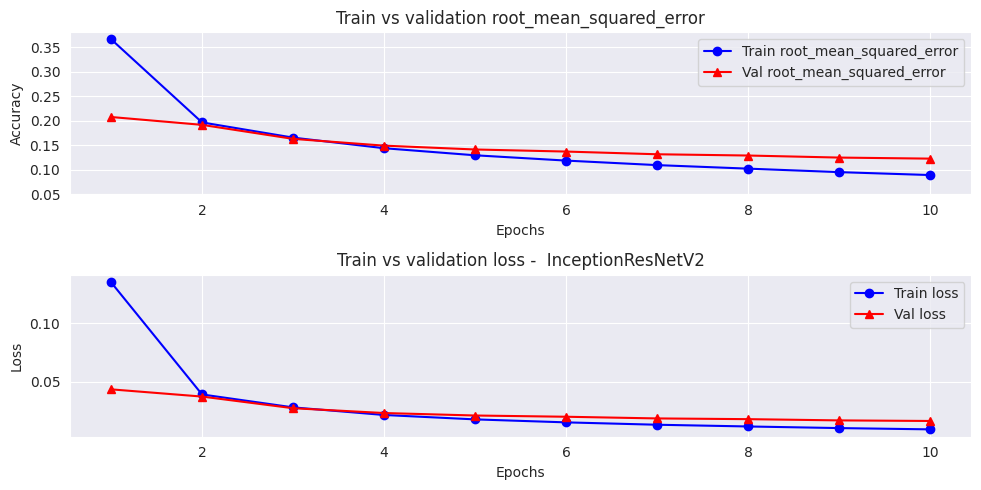

In [21]:
sns.set_style('darkgrid')

fig, axs = plt.subplots(2, figsize=(10, 5))
model_train_acc = history.history['root_mean_squared_error']
epochs_train_acc = range(1,len(model_train_acc)+1)
model_val_acc = history.history['val_root_mean_squared_error']
epochs_val_acc = range(1,len(model_val_acc)+1)
epochs_val_acc = range(1,len(model_val_acc)+1)

axs[0].plot(epochs_train_acc,model_train_acc, marker = 'o', c = 'b',label = 'Train root_mean_squared_error')
axs[0].plot(epochs_val_acc,model_val_acc, marker = '^' , c = 'r', label = 'Val root_mean_squared_error')
axs[0].set_title('Train vs validation root_mean_squared_error')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_yticks(np.arange(round_nearest(min(min(model_train_acc), min(model_val_acc)),0.05),round_nearest(max(max(model_train_acc), max(model_val_acc)),0.05), 0.05))

model_train_loss = history.history['loss']
epochs_train_loss = range(1,len(model_train_loss)+1)
model_val_loss = history.history['val_loss']
epochs_val_loss = range(1,len(model_val_loss)+1)

axs[1].plot(epochs_train_loss,model_train_loss, marker = 'o', c = 'b', label = 'Train loss')
axs[1].plot(epochs_val_loss,model_val_loss, marker = '^', c= 'r' ,label = 'Val loss')
axs[1].set_title('Train vs validation loss -  InceptionResNetV2')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
# axs[1].set_yticks(np.arange(round_nearest(min(min(model_train_loss), min(model_val_loss)),0.5),round_nearest(max(max(model_train_loss), max(model_val_loss)),0.5), 0.5))

fig.tight_layout()

In [22]:
recommender.evaluate(x_test,y_test)

730/730 [==============================] - 3s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1202


[0.01618069037795067, 0.12020788341760635]

In [23]:
y_test

array([1., 1., 0., ..., 1., 1., 1.])

In [24]:
z = x_test.copy()
z = pd.DataFrame(z)
z.rename(columns = {0:'user', 1:'item'}, inplace = True)

In [25]:
z

,user,item
0,16103,27
1,17742,30
2,31855,81
3,1816,3
4,10932,27
...,...,...
23326,22658,30
23327,21876,23
23328,2999,66
23329,11082,56


In [26]:
rating_df

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0
...,...,...,...
233301,1540125,DS0101EN,3.0
233302,1250651,PY0101EN,3.0
233303,1003832,CB0105ENv1,3.0
233304,922065,BD0141EN,3.0


In [27]:
# Mapping user ids to indices
user_list = rating_df["user"].unique().tolist()
user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
user_idx2id_dict = {i: x for i, x in enumerate(user_list)}

# Mapping course ids to indices
course_list = rating_df["item"].unique().tolist()
course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
course_idx2id_dict = {i: x for i, x in enumerate(course_list)}
# Convert original user ids to idx
z["user"] = z["user"].map(user_idx2id_dict)
# Convert original course ids to idx
z["item"] = z["item"].map(course_idx2id_dict)

In [28]:
z

,user,item
0,1324536,ML0101ENv3
1,1449664,RP0101EN
2,475637,TMP0105EN
3,955511,BD0211EN
4,1095915,ML0101ENv3
...,...,...
23326,1770571,RP0101EN
23327,1156390,PY0101EN
23328,522734,BD0115EN
23329,947800,CO0401EN


In [29]:
pred = recommender.predict(x_test)

730/730 [==============================] - 2s 2ms/step


In [30]:
pred

array([[1.0592165 ],
       [1.0080419 ],
       [0.47646263],
       ...,
       [1.024018  ],
       [0.9957163 ],
       [0.9826438 ]], dtype=float32)

In [31]:
z['score'] = pred
z

,user,item,score
0,1324536,ML0101ENv3,1.059216
1,1449664,RP0101EN,1.008042
2,475637,TMP0105EN,0.476463
3,955511,BD0211EN,1.030436
4,1095915,ML0101ENv3,1.039331
...,...,...,...
23326,1770571,RP0101EN,1.005826
23327,1156390,PY0101EN,0.994872
23328,522734,BD0115EN,1.024018
23329,947800,CO0401EN,0.995716


In [32]:
z.sort_values(by = 'score', ascending=False, inplace = True)

In [33]:
z[z['user']==1324536	]

,user,item,score
12381,1324536,ML0120ENv2,1.066609
0,1324536,ML0101ENv3,1.059216


In [34]:
recommender.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embe  multiple                  542416    
 dding)                                                          
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embe  multiple                  2016      
 dding)                                                          
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578459 (2.21 MB)
Trainable params: 578459 (2.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# User features
user_latent_features = recommender.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [36]:
user_latent_features[0]

array([ 0.07327475, -0.03086315, -0.02384394, -0.07750668, -0.08428173,
        0.03890469,  0.00116806, -0.04208441, -0.0284832 ,  0.09870969,
        0.0267128 ,  0.03732621, -0.00764901, -0.01220682, -0.00036325,
        0.11305546], dtype=float32)

In [37]:
item_latent_features = recommender.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [38]:
item_latent_features[0]

array([-0.00940265, -0.01364874,  0.0177348 ,  0.00071713,  0.00302088,
        0.020182  ,  0.01443627,  0.01030627,  0.00332417, -0.02061116,
       -0.00328072, -0.0006808 , -0.02368016,  0.01689673, -0.00702456,
        0.03203112], dtype=float32)